<a href="https://colab.research.google.com/github/Luck1e23/STA160-Team-11-Project/blob/laiq/Resnet50_retry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q torchxrayvision
!pip install -q iterative-stratification
!pip install -q validators matplotlib

# =========================
# Imports
# =========================

from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import Adam
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from pathlib import Path

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as tvF
import torch.nn.functional as F

# Pre-trained Model: torchvision ResNet
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.2 MB/s eta 0:00:00
Using device: cuda


In [2]:
file_path = '/content/drive/Shareddrives/STA_160/dataset/Data_Entry_2017.csv'
train_val = '/content/drive/Shareddrives/STA_160/dataset/train_val_list.txt'
test = '/content/drive/Shareddrives/STA_160/dataset/test_list.txt'
resized_root = '/content/dataset_resized'

# Unzip resized images
!unzip -q /content/drive/Shareddrives/STA_160/NIH_resized.zip -d /content/dataset

!mkdir -p /content/dataset_resized
# Move all pngs into /content/dataset_resized
!find /content/dataset/content/dataset_resized/ -type f -exec mv -t /content/dataset_resized/ {} +
!rm -rf /content/dataset/content


In [3]:
class NIHXrays(Dataset):
    def __init__(self, file_path, dataset_root, list_file=None, transform=None):
        self.data = pd.read_csv(file_path)
        self.dataset_root = dataset_root
        self.transform = transform

        # Optional filtering by train_val_list or test_list
        if list_file:
            with open(list_file, 'r') as f:
                image_list = {line.strip() for line in f.readlines()}
            self.data = self.data[self.data['Image Index'].isin(image_list)].reset_index(drop=True)

        # Create label map
        all_labels = set()
        for labels in self.data['Finding Labels']:
            for l in labels.split('|'):
                all_labels.add(l.strip())

        self.all_labels = sorted(all_labels)
        self.label_map = {label: i for i, label in enumerate(self.all_labels)}

        # Build multi hot label vectors
        self.finding_labels = []
        for labels in self.data['Finding Labels']:
            vec = torch.zeros(len(self.all_labels))
            for l in labels.split('|'):
                if l.strip() in self.label_map:
                    vec[self.label_map[l.strip()]] = 1.0
            self.finding_labels.append(vec)

        self.finding_labels = torch.stack(self.finding_labels).float()

        # Recursively map image filenames to full paths
        self.image_map = {}
        for img_path in Path(dataset_root).rglob("*.png"):
            self.image_map[img_path.name] = str(img_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image Index']

        if img_name not in self.image_map:
            raise FileNotFoundError(f"Image {img_name} not found.")

        # Load image as grayscale first
        img = Image.open(self.image_map[img_name]).convert("L")

        # Apply augmentation on the PIL image
        if self.transform is not None:
            img = self.transform(img)

        # Convert to NumPy and scale to [0, 1]
        img = np.array(img).astype(np.float32) / 255.0  # [H, W]

        # To tensor with shape [1, H, W]
        img = torch.from_numpy(img).unsqueeze(0)

        # Repeat to make 3 channels for ResNet50: [3, H, W]
        img = img.repeat(3, 1, 1)

        # ImageNet normalization for ResNet50
        img = tvF.normalize(
            img,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        label = self.finding_labels[idx].float()

        return img, label, img_name

# Data augmentation for training
rand_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip()
])

train_val_data = NIHXrays(file_path, resized_root, list_file=train_val, transform=rand_transforms)
test_data      = NIHXrays(file_path, resized_root, list_file=test, transform=None)

print("Number of train+val images:", len(train_val_data))
print("Number of test images:", len(test_data))
print("Label set:", train_val_data.all_labels)


Number of train+val images: 86524
Number of test images: 25596
Label set: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
# Multi label stratified split
y = train_val_data.finding_labels.numpy()   # [N, C]
X = np.arange(len(train_val_data))

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, valid_idx = next(msss.split(X, y))

train_data = Subset(train_val_data, train_idx)
valid_data = Subset(train_val_data, valid_idx)

print("Train samples:", len(train_data))
print("Valid samples:", len(valid_data))

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)


Train samples: 69200
Valid samples: 17324


In [5]:
def compute_pos_weights(subset):
    full_dataset = subset.dataset
    labels = full_dataset.finding_labels[subset.indices].numpy()

    pos_counts = labels.sum(axis=0)
    neg_counts = (labels == 0).sum(axis=0)
    pos_weight = neg_counts / (pos_counts + 1e-6)

    return torch.tensor(pos_weight, dtype=torch.float32)

pos_weight = compute_pos_weights(train_data).to(device)
pos_weight = torch.clamp(pos_weight, max=30)

class Focal_Loss(nn.Module):
    def __init__(self, gamma=2.0, pos_weight=None):
        super().__init__()
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            pos_weight=self.pos_weight,
            reduction='none'
        )

        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)

        focal_factor = (1 - p_t) ** self.gamma
        loss = focal_factor * bce
        return loss.mean()

loss_function = Focal_Loss(gamma=2.0, pos_weight=pos_weight)

def pr_curve_thresholds(y_true, y_prob, min_thresh=0.1):
    num_labels = y_true.shape[1]
    thresholds = np.zeros(num_labels)

    for i in range(num_labels):
        p, r, t = precision_recall_curve(y_true[:, i], y_prob[:, i])
        f1 = 2 * p * r / (p + r + 1e-9)

        if len(t) == 0:
            thresholds[i] = min_thresh
        else:
            thresholds[i] = t[np.argmax(f1)]

    return thresholds

def compute_f1(y_true, y_prob, thresholds):
    # y_true, y_prob are tensors
    y_true = y_true.cpu()
    y_prob = y_prob.cpu()

    thresholds = torch.tensor(thresholds, dtype=y_prob.dtype)
    y_pred = (y_prob >= thresholds.unsqueeze(0)).int()

    return f1_score(y_true, y_pred, average="macro", zero_division=0)

def compute_auc(y_true, y_prob):
    # y_true, y_prob are tensors
    y_true = y_true.detach().cpu().numpy()
    y_prob = y_prob.detach().cpu().numpy()
    return roc_auc_score(y_true, y_prob, average="macro")


In [6]:
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    for imgs, labels, _ in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        batch_loss = loss_fn(outputs, labels)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

        probs = torch.sigmoid(outputs)
        all_probs.append(probs.detach().cpu())
        all_labels.append(labels.detach().cpu())

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    auc = compute_auc(all_labels, all_probs)
    epoch_loss = total_loss / len(train_loader)

    print(f"Train - Loss: {epoch_loss:.4f}, AUC: {auc:.4f}")
    return epoch_loss, auc


def validate_epoch(model, valid_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels, _ in valid_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            batch_loss = loss_fn(outputs, labels)

            total_loss += batch_loss.item()

            probs = torch.sigmoid(outputs)
            all_probs.append(probs.detach().cpu())
            all_labels.append(labels.detach().cpu())

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    epoch_loss = total_loss / len(valid_loader)
    thresholds = pr_curve_thresholds(all_labels.numpy(), all_probs.numpy())
    valid_f1 = compute_f1(all_labels, all_probs, thresholds)
    valid_auc = compute_auc(all_labels, all_probs)

    print(f"Valid - Loss: {epoch_loss:.4f}, F1: {valid_f1:.4f}, AUC: {valid_auc:.4f}")
    return epoch_loss, valid_f1, valid_auc, thresholds


In [7]:
# Number of classes
N_CLASSES = len(train_val_data.all_labels)
print("Number of classes:", N_CLASSES)

# Build ResNet50 with ImageNet weights
weights = ResNet50_Weights.IMAGENET1K_V2
resnet_model = resnet50(weights=weights)

in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, N_CLASSES)

resnet_model = resnet_model.to(device)

print("Using torchvision ResNet50 backbone")

# Stage 1 - train only fc layer
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.fc.parameters():
    param.requires_grad = True

optimizer = Adam(resnet_model.fc.parameters(), lr=1e-3)

best_val_auc = 0.0
best_model_path = "/content/drive/Shareddrives/STA_160/nih_resnet50_finetuned_best.pth"

EPOCHS_STAGE1 = 3

for epoch in range(1, EPOCHS_STAGE1 + 1):
    print(f"\n[Stage 1] Epoch {epoch}/{EPOCHS_STAGE1}")

    train_loss, train_auc = train_epoch(
        model=resnet_model,
        train_loader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_function,
        device=device
    )

    valid_loss, valid_f1, valid_auc, thresholds = validate_epoch(
        model=resnet_model,
        valid_loader=valid_loader,
        loss_fn=loss_function,
        device=device
    )

    if valid_auc > best_val_auc:
        best_val_auc = valid_auc
        torch.save(resnet_model.state_dict(), best_model_path)
        print(f"New BEST model (Stage 1) saved with AUC {best_val_auc:.4f}")


Number of classes: 15
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Using torchvision ResNet50 backbone

[Stage 1] Epoch 1/3
Train - Loss: 0.2485, AUC: 0.6613
Valid - Loss: 0.2365, F1: 0.1987, AUC: 0.7069
New BEST model (Stage 1) saved with AUC 0.7069

[Stage 1] Epoch 2/3
Train - Loss: 0.2429, AUC: 0.6953
Valid - Loss: 0.2418, F1: 0.2039, AUC: 0.7150
New BEST model (Stage 1) saved with AUC 0.7150

[Stage 1] Epoch 3/3
Train - Loss: 0.2417, AUC: 0.7043
Valid - Loss: 0.2491, F1: 0.1996, AUC: 0.7092


In [8]:
for param in resnet_model.parameters():
    param.requires_grad = True

optimizer = Adam(resnet_model.parameters(), lr=1e-5)

EPOCHS_STAGE2 = 20

for epoch in range(EPOCHS_STAGE1 + 1, EPOCHS_STAGE1 + EPOCHS_STAGE2 + 1):
    print(f"\n[Stage 2] Epoch {epoch}/{EPOCHS_STAGE1 + EPOCHS_STAGE2}")

    train_loss, train_auc = train_epoch(
        model=resnet_model,
        train_loader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_function,
        device=device
    )

    valid_loss, valid_f1, valid_auc, thresholds = validate_epoch(
        model=resnet_model,
        valid_loader=valid_loader,
        loss_fn=loss_function,
        device=device
    )

    if valid_auc > best_val_auc:
        best_val_auc = valid_auc
        torch.save(resnet_model.state_dict(), best_model_path)
        print(f"New BEST model (Stage 2) saved with AUC {best_val_auc:.4f}")

# Save final epoch model too
final_model_path = "/content/drive/Shareddrives/STA_160/nih_resnet50_finetuned_final.pth"
torch.save(resnet_model.state_dict(), final_model_path)
print("Final epoch model saved to:", final_model_path)
print("Best model saved to:", best_model_path)


[Stage 2] Epoch 4/23
Train - Loss: 0.2225, AUC: 0.7525
Valid - Loss: 0.2231, F1: 0.2303, AUC: 0.7512
New BEST model (Stage 2) saved with AUC 0.7512

[Stage 2] Epoch 5/23
Train - Loss: 0.2135, AUC: 0.7791
Valid - Loss: 0.2173, F1: 0.2438, AUC: 0.7668
New BEST model (Stage 2) saved with AUC 0.7668

[Stage 2] Epoch 6/23
Train - Loss: 0.2073, AUC: 0.7965
Valid - Loss: 0.2142, F1: 0.2564, AUC: 0.7774
New BEST model (Stage 2) saved with AUC 0.7774

[Stage 2] Epoch 7/23
Train - Loss: 0.2016, AUC: 0.8098
Valid - Loss: 0.2124, F1: 0.2666, AUC: 0.7805
New BEST model (Stage 2) saved with AUC 0.7805

[Stage 2] Epoch 8/23
Train - Loss: 0.1968, AUC: 0.8213
Valid - Loss: 0.2114, F1: 0.2716, AUC: 0.7876
New BEST model (Stage 2) saved with AUC 0.7876

[Stage 2] Epoch 9/23
Train - Loss: 0.1917, AUC: 0.8327
Valid - Loss: 0.2097, F1: 0.2776, AUC: 0.7907
New BEST model (Stage 2) saved with AUC 0.7907

[Stage 2] Epoch 10/23
Train - Loss: 0.1871, AUC: 0.8411
Valid - Loss: 0.2101, F1: 0.2870, AUC: 0.7966
New

KeyboardInterrupt: 

In [9]:
# Rebuild architecture and load best weights
eval_model = resnet50(weights=None)
in_features = eval_model.fc.in_features
eval_model.fc = nn.Linear(in_features, N_CLASSES)

state_dict = torch.load(best_model_path, map_location=device)
eval_model.load_state_dict(state_dict)
eval_model = eval_model.to(device)
eval_model.eval()

print("Loaded best model from:", best_model_path)

def collect_outputs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            probs = torch.sigmoid(outputs)

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    return all_labels.numpy(), all_probs.numpy()

# Validation metrics
val_labels, val_probs = collect_outputs(eval_model, valid_loader, device)
val_thresholds = pr_curve_thresholds(val_labels, val_probs)

per_label_auc_val = []
per_label_f1_val = []

for i in range(val_labels.shape[1]):
    auc_i = roc_auc_score(val_labels[:, i], val_probs[:, i])
    thr = val_thresholds[i]
    y_pred_i = (val_probs[:, i] >= thr).astype(int)
    f1_i = f1_score(val_labels[:, i], y_pred_i, zero_division=0)

    per_label_auc_val.append(auc_i)
    per_label_f1_val.append(f1_i)

print("Validation Macro AUC:", np.mean(per_label_auc_val))
print("Validation Macro F1 :", np.mean(per_label_f1_val))

# Test metrics
test_labels, test_probs = collect_outputs(eval_model, test_loader, device)

per_label_auc_test = []
per_label_f1_test = []

for i in range(test_labels.shape[1]):
    auc_i = roc_auc_score(test_labels[:, i], test_probs[:, i])
    thr = val_thresholds[i]
    y_pred_i = (test_probs[:, i] >= thr).astype(int)
    f1_i = f1_score(test_labels[:, i], y_pred_i, zero_division=0)

    per_label_auc_test.append(auc_i)
    per_label_f1_test.append(f1_i)

print("Test Macro AUC:", np.mean(per_label_auc_test))
print("Test Macro F1 :", np.mean(per_label_f1_test))

# Per label results table
results_df = pd.DataFrame({
    "Label": train_val_data.all_labels,
    "Val AUC": per_label_auc_val,
    "Val F1": per_label_f1_val,
    "Test AUC": per_label_auc_test,
    "Test F1": per_label_f1_test,
    "Threshold": val_thresholds
})

results_df


Loaded best model from: /content/drive/Shareddrives/STA_160/nih_resnet50_finetuned_best.pth
Validation Macro AUC: 0.794817985693404
Validation Macro F1 : 0.28380333160149335
Test Macro AUC: 0.7568029424760044
Test Macro F1 : 0.29457656370608837


,Label,Val AUC,Val F1,Test AUC,Test F1,Threshold
0,Atelectasis,0.780444,0.349059,0.713083,0.334073,0.569362
1,Cardiomegaly,0.879940,0.282238,0.852411,0.350000,0.690623
2,Consolidation,0.784247,0.183716,0.690276,0.197470,0.598213
3,Edema,0.879351,0.249423,0.808926,0.198297,0.633675
4,Effusion,0.860490,0.474689,0.784389,0.475216,0.574137
5,Emphysema,0.882672,0.335008,0.868180,0.376246,0.670614
6,Fibrosis,0.771519,0.134783,0.786107,0.116402,0.640341
7,Hernia,0.863819,0.085561,0.860811,0.215909,0.505433
8,Infiltration,0.681622,0.348477,0.668576,0.437959,0.508324
9,Mass,0.794337,0.290566,0.733161,0.256066,0.600420


from matplotlib import pyplot as plt
results_df['Val AUC'].plot(kind='hist', bins=20, title='Val AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Val F1'].plot(kind='hist', bins=20, title='Val F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Test AUC'].plot(kind='hist', bins=20, title='Test AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Test F1'].plot(kind='hist', bins=20, title='Test F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Val AUC', y='Val F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Val F1', y='Test AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Test AUC', y='Test F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Test F1', y='Threshold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Val AUC'].plot(kind='line', figsize=(8, 4), title='Val AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['Val F1'].plot(kind='line', figsize=(8, 4), title='Val F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['Test AUC'].plot(kind='line', figsize=(8, 4), title='Test AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['Test F1'].plot(kind='line', figsize=(8, 4), title='Test F1')
plt.gca().spines[['top', 'right']].set_visible(False)

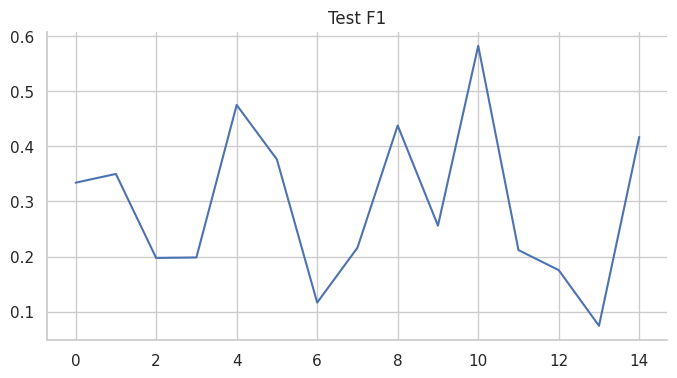

In [16]:
from matplotlib import pyplot as plt
results_df['Test F1'].plot(kind='line', figsize=(8, 4), title='Test F1')
plt.gca().spines[['top', 'right']].set_visible(False)

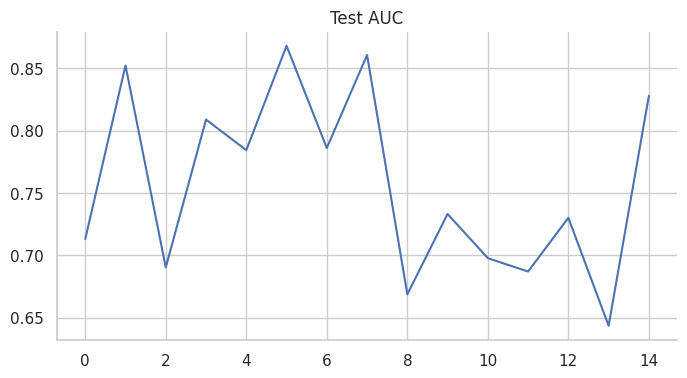

In [17]:
from matplotlib import pyplot as plt
results_df['Test AUC'].plot(kind='line', figsize=(8, 4), title='Test AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

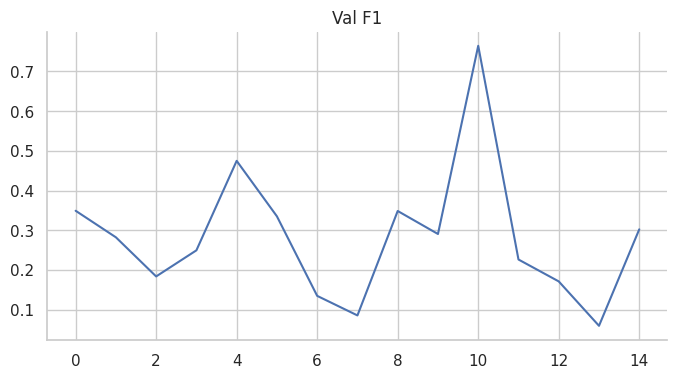

In [18]:
from matplotlib import pyplot as plt
results_df['Val F1'].plot(kind='line', figsize=(8, 4), title='Val F1')
plt.gca().spines[['top', 'right']].set_visible(False)

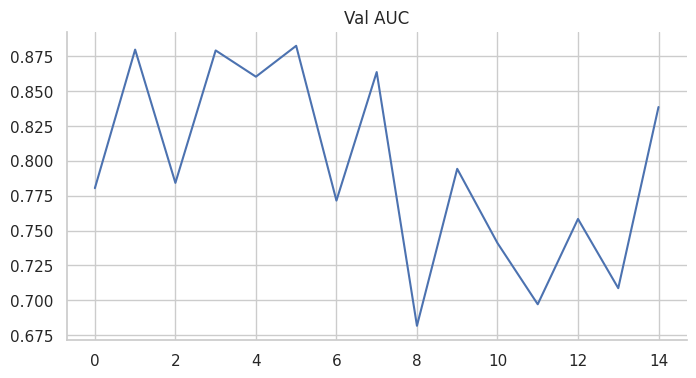

In [19]:
from matplotlib import pyplot as plt
results_df['Val AUC'].plot(kind='line', figsize=(8, 4), title='Val AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

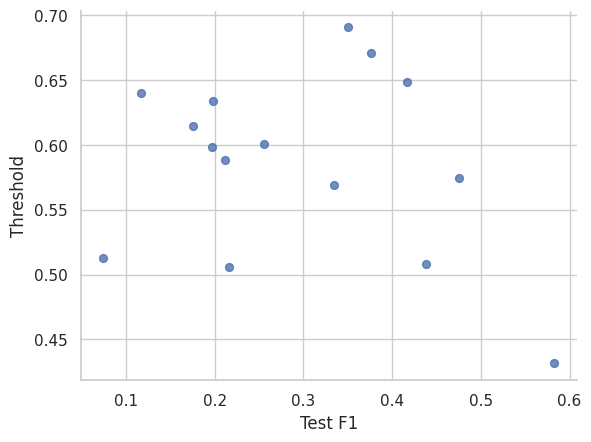

In [20]:
from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Test F1', y='Threshold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

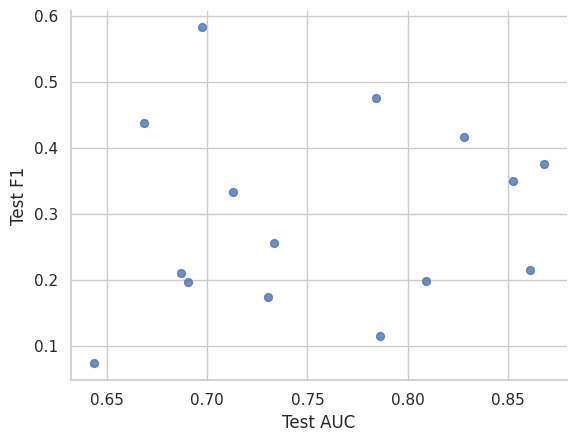

In [21]:
from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Test AUC', y='Test F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

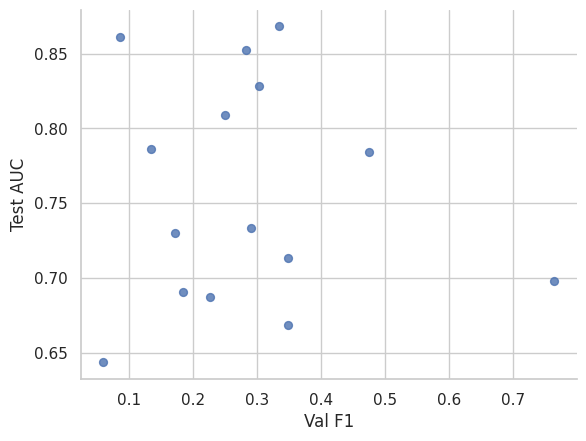

In [22]:
from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Val F1', y='Test AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

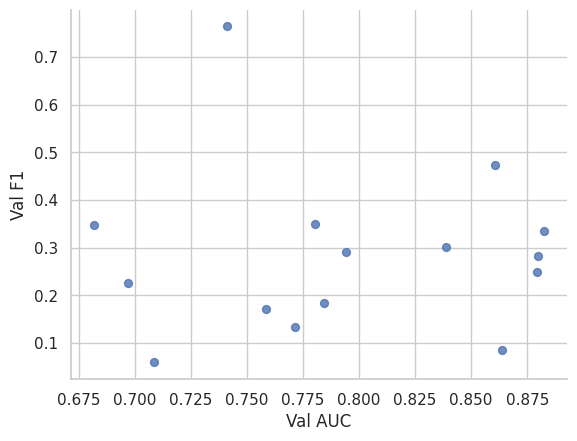

In [23]:
from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Val AUC', y='Val F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

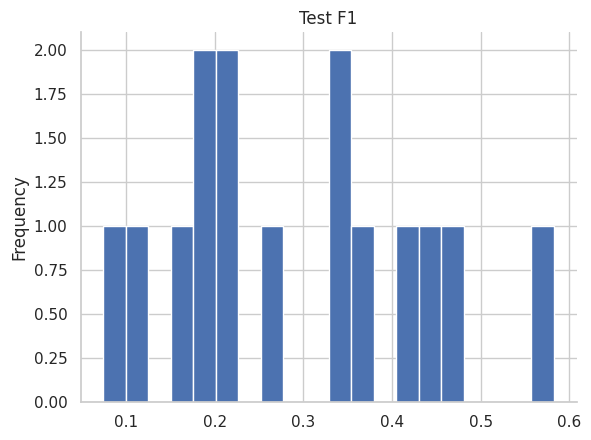

In [24]:
from matplotlib import pyplot as plt
results_df['Test F1'].plot(kind='hist', bins=20, title='Test F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

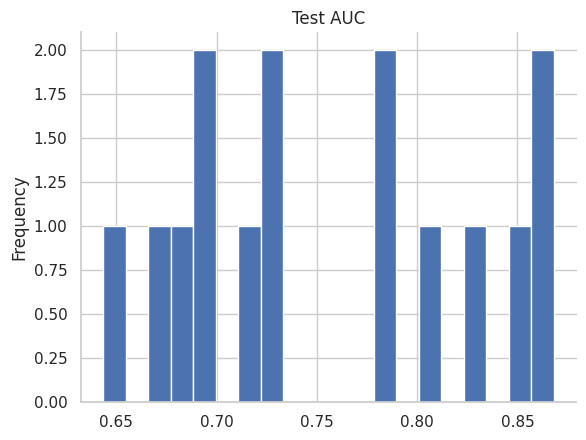

In [25]:
from matplotlib import pyplot as plt
results_df['Test AUC'].plot(kind='hist', bins=20, title='Test AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

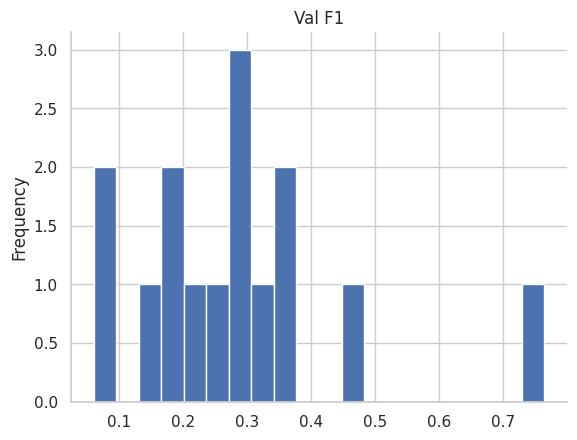

In [15]:
from matplotlib import pyplot as plt
results_df['Val F1'].plot(kind='hist', bins=20, title='Val F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

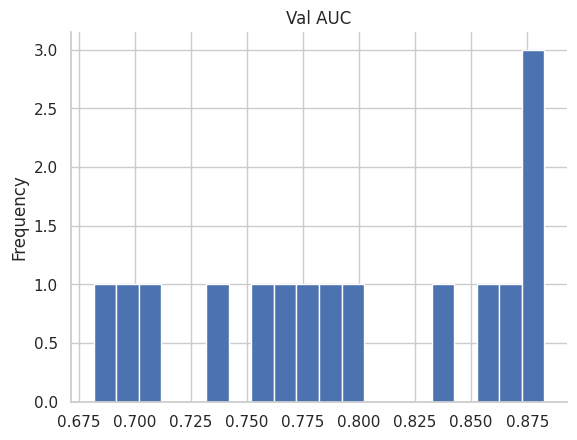

In [14]:
from matplotlib import pyplot as plt
results_df['Val AUC'].plot(kind='hist', bins=20, title='Val AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

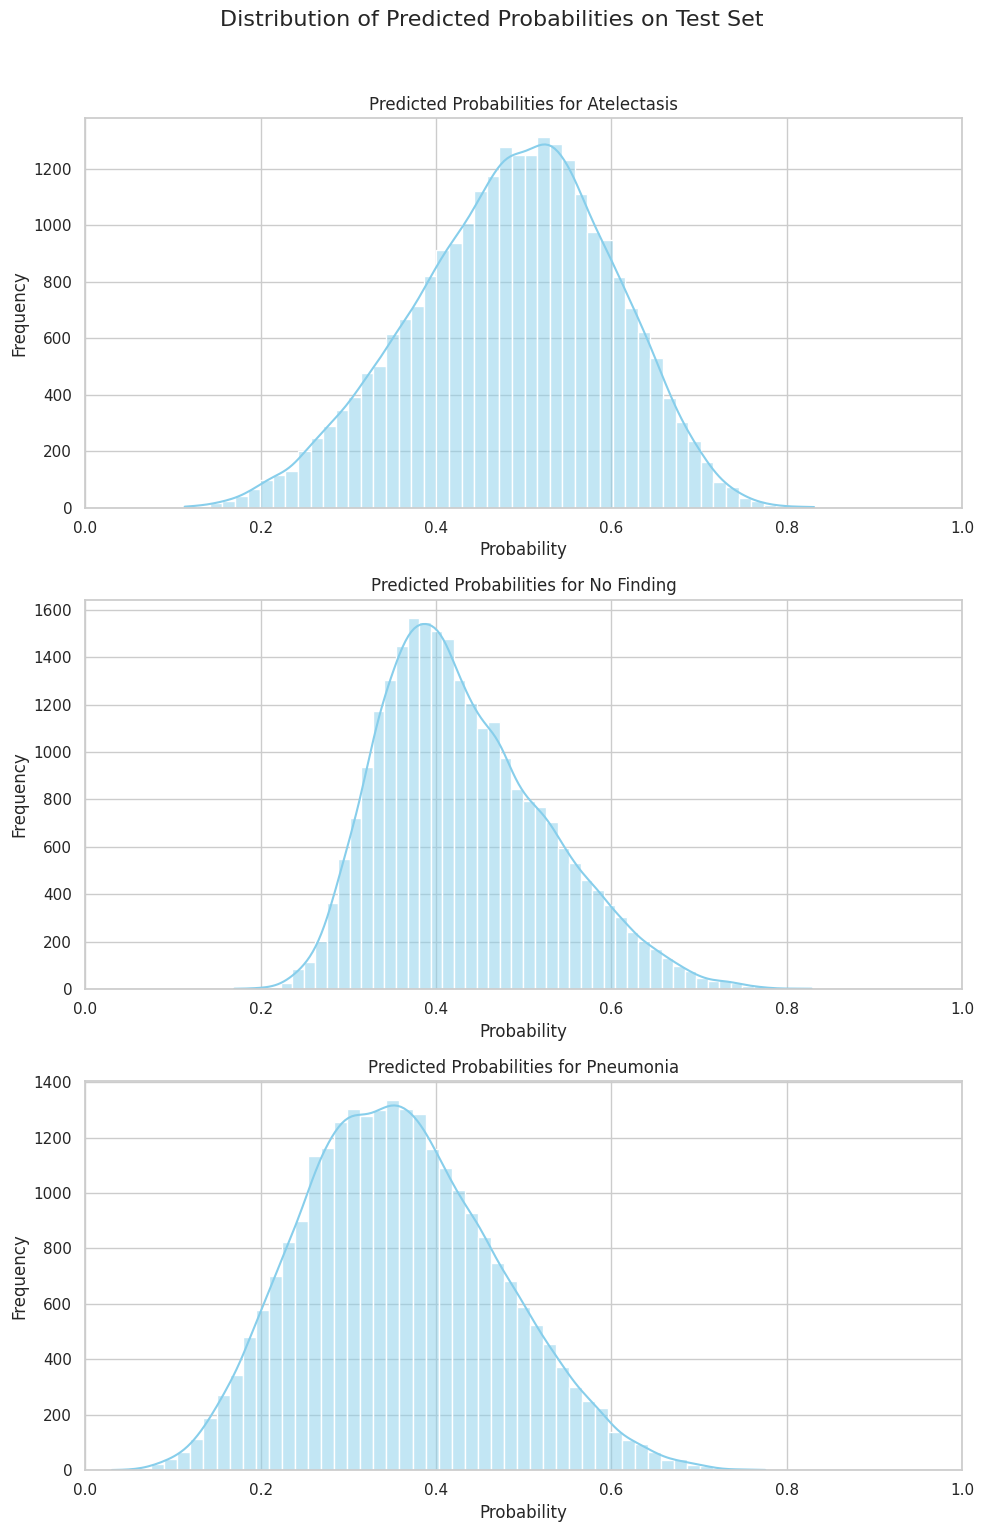

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

# Get a few example labels to visualize their probability distributions
example_labels = ['Atelectasis', 'No Finding', 'Pneumonia']
example_indices = [results_df[results_df['Label'] == label].index[0] for label in example_labels]

fig, axes = plt.subplots(len(example_labels), 1, figsize=(10, 5 * len(example_labels)))
fig.suptitle('Distribution of Predicted Probabilities on Test Set', fontsize=16, y=1.02)

for i, idx in enumerate(example_indices):
    label_name = results_df.loc[idx, 'Label']
    sns.histplot(test_probs[:, idx], bins=50, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Predicted Probabilities for {label_name}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim([0, 1]) # Probabilities are between 0 and 1

plt.tight_layout()
plt.show()

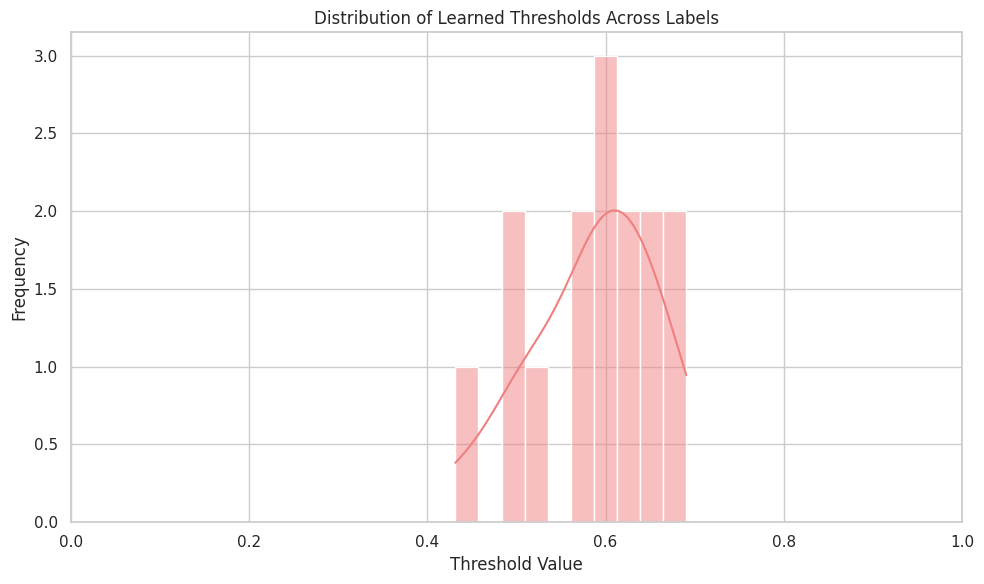

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(results_df['Threshold'], bins=10, kde=True, color='lightcoral')
plt.title('Distribution of Learned Thresholds Across Labels')
plt.xlabel('Threshold Value')
plt.ylabel('Frequency')
plt.xlim([0, 1]) # Thresholds are between 0 and 1
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

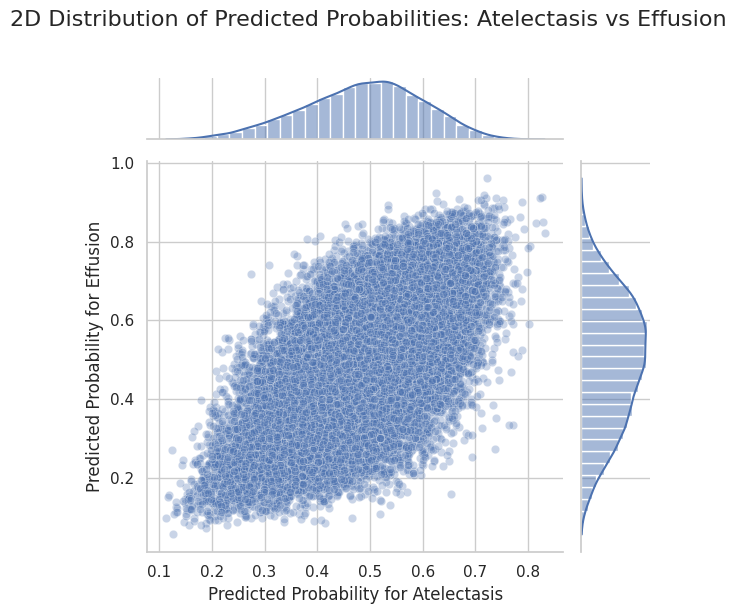

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

# Select two labels to visualize their 2D probability distribution
# For example: 'Atelectasis' and 'Effusion'
label1_name = 'Atelectasis'
label2_name = 'Effusion'

label1_idx = results_df[results_df['Label'] == label1_name].index[0]
label2_idx = results_df[results_df['Label'] == label2_name].index[0]

prob1 = test_probs[:, label1_idx]
prob2 = test_probs[:, label2_idx]

plt.figure(figsize=(10, 8))
sns.jointplot(x=prob1, y=prob2, kind='scatter', alpha=0.3, marginal_kws=dict(bins=30, kde=True))
plt.xlabel(f'Predicted Probability for {label1_name}')
plt.ylabel(f'Predicted Probability for {label2_name}')
plt.suptitle(f'2D Distribution of Predicted Probabilities: {label1_name} vs {label2_name}', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
csv_path = '/content/drive/Shareddrives/STA_160/results_df.csv'
results_df.to_csv(csv_path, index=False)
print(f"results_df saved to {csv_path}")

results_df saved to /content/drive/Shareddrives/STA_160/results_df.csv
